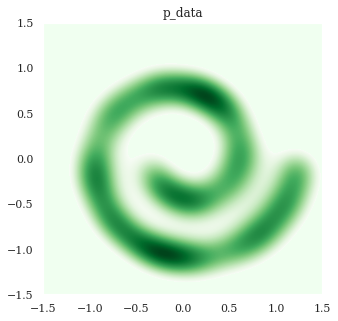

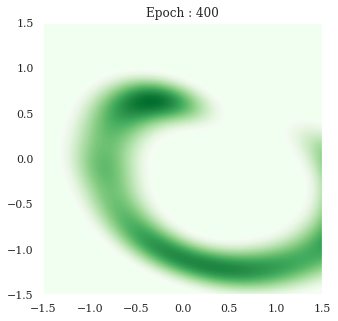

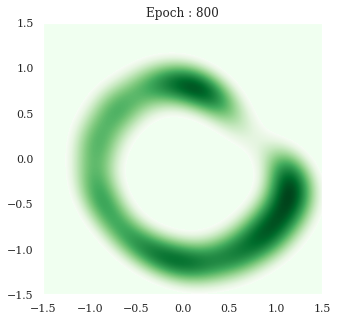

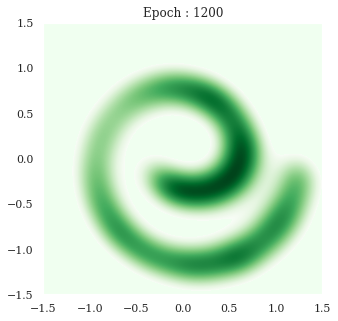

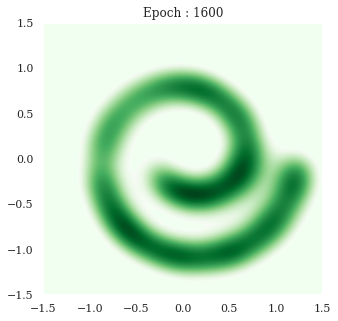

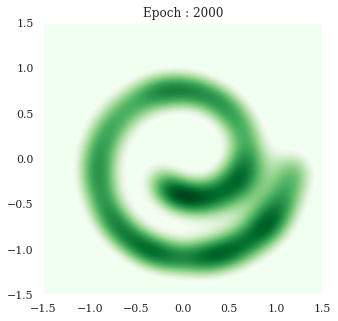

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim

"""
Step 0 : Define training configurations
"""

batch_size = 64
learning_rate = 5e-4
num_epochs = 2000
reg_coeff = 150
latent_dim1 = 32
latent_dim2 = 128
device = "cuda:0" if torch.cuda.is_available() else "cpu"

"""
Step 1 : Define custom dataset 
"""


def make_swiss_roll(n_samples=2000, noise=1.0, dimension=2, a=20, b=5):
    """
    Generate 2D swiss roll dataset
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25, 4, n_samples))

    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)

    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size=n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T


def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize=(5, 5))
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    plt.rc('font', size=10)

    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title(title)
    plt.show()


"""
Step 2 : Define custom dataset and dataloader. 
"""


class SwissRollDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = torch.from_numpy(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
plt.figure(figsize=(5, 5))
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', size=10)

g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

g.grid(False)
plt.margins(0, 0)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title('p_data')
plt.savefig('swiss_roll_true.png')
plt.show()

"""
Step 3 : Implement models
"""
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(1, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 2)

    def forward(self, input):
        z = input.view(input.size(0), -1)
        z = self.fc1(z)
        z = torch.tanh(z)
        output = self.fc2(z)
        return output

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2, latent_dim)
        self.fc2 = nn.Linear(latent_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 1)

    def forward(self, input):
        z = torch.tanh(self.fc1(input))
        z = torch.tanh(self.fc2(z))
        output = torch.sigmoid(self.fc3(z))
        return output


"""
Step 4 : Train models
"""
Generator = Generator(latent_dim1).to(device)
Discriminator = Discriminator(latent_dim2).to(device)
optimizer_G = optim.Adam(Generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(Discriminator.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch_idx, x in enumerate(loader):
        x = x.to(device).float()

        optimizer_D.zero_grad()
        loss_D_real = torch.mean(torch.log(Discriminator(x)))
        z = torch.randn(batch_size, 1).to(device)
        loss_D_fake = torch.mean(torch.log(1 - Discriminator(Generator(z))))
        loss_D_all = -(loss_D_real + loss_D_fake)
        loss_D_all.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, 1).to(device)
        loss_G_all = torch.mean(torch.log(1 - Discriminator(Generator(z))))
        loss_G_all.backward()
        optimizer_G.step()

    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == (num_epochs // 5 - 1):
        z = torch.randn(2000, 1).to(device)
        data = Generator(z).cpu().detach()
        show_data(data, f"Epoch : {epoch + 1}")

